In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, random_split

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torchvision.models import EfficientNet_B0_Weights

from tqdm import tqdm

from sklearn.model_selection import train_test_split

In [2]:
# import time

# with tqdm(total=10, desc="Train") as pbar:
#     for i in range(10):
#         time.sleep(1)
#         pbar.update(1)

In [3]:

lr = 1e-4
epochs = 50

# 입력 이미지 (3, 32, 32)
# 출력 label -> 0~9
classes = 10

train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

train_ratio = 0.8
batch_size = 128  # 원하는 배치 크기 설정
num_workers = 4

In [4]:
# 데이터 증강 및 정규화를 위한 변환 설정
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # 데이터 증강: 랜덤하게 잘라내기
    transforms.RandomHorizontalFlip(),      # 데이터 증강: 랜덤하게 좌우 반전
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet 정규화 값
])

# test셋은 증식 X
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet 정규화 값
])

# CIFAR10 데이터셋 불러오기
full_train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)


# random split을 사용하여 데이터셋을 나눔
# train_size = int(len(full_train_dataset) * train_ratio)
# valid_size = len(full_train_dataset) - train_size
# train_dataset, valid_dataset = random_split(full_train_dataset, [train_size, valid_size])

# 레이블을 추출 (각 데이터의 클래스 라벨)
labels = [full_train_dataset[i][1] for i in range(len(full_train_dataset))]

# train_test_split을 사용하여 데이터셋을 균등하게 나눔 (stratify 사용)
train_indices, valid_indices = train_test_split(
    range(len(full_train_dataset)),
    test_size=0.2,  # 검증 데이터 비율 (20%)
    stratify=labels,  # 클래스 비율을 유지하면서 분할
    random_state=42  # 결과 재현성을 위해 랜덤 시드 고정
)

# Subset을 사용하여 나눈 인덱스를 기반으로 학습과 검증 데이터셋을 생성
train_dataset = Subset(full_train_dataset, train_indices)
valid_dataset = Subset(full_train_dataset, valid_indices)

# 데이터 로더 생성
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
import numpy as np
from collections import Counter

# CIFAR-10에서 클래스는 0~9까지
num_classes = 10

# Train 데이터셋의 라벨 분포 확인
train_labels = [full_train_dataset[i][1] for i in train_dataset.indices]
train_label_counts = Counter(train_labels)

print("Train dataset class distribution:")
for i in range(num_classes):
    print(f"Class {i}: {train_label_counts[i]} samples")

# Valid 데이터셋의 라벨 분포 확인
valid_labels = [full_train_dataset[i][1] for i in valid_dataset.indices]
valid_label_counts = Counter(valid_labels)

print("\nValidation dataset class distribution:")
for i in range(num_classes):
    print(f"Class {i}: {valid_label_counts[i]} samples")

Train dataset class distribution:
Class 0: 4000 samples
Class 1: 4000 samples
Class 2: 4000 samples
Class 3: 4000 samples
Class 4: 4000 samples
Class 5: 4000 samples
Class 6: 4000 samples
Class 7: 4000 samples
Class 8: 4000 samples
Class 9: 4000 samples

Validation dataset class distribution:
Class 0: 1000 samples
Class 1: 1000 samples
Class 2: 1000 samples
Class 3: 1000 samples
Class 4: 1000 samples
Class 5: 1000 samples
Class 6: 1000 samples
Class 7: 1000 samples
Class 8: 1000 samples
Class 9: 1000 samples


In [6]:
class CIFAR10Net(nn.Module):
    def __init__(self):
        super(CIFAR10Net, self).__init__()
        # 합성곱 레이어 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # 입력 채널: 3, 출력 채널: 32
        self.bn1 = nn.BatchNorm2d(32)  # 배치 정규화
        
        # 합성곱 레이어 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # 입력 채널: 32, 출력 채널: 64
        self.bn2 = nn.BatchNorm2d(64)

        # 합성곱 레이어 3
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # 입력 채널: 64, 출력 채널: 128
        self.bn3 = nn.BatchNorm2d(128)

        # 완전 연결 레이어
        self.fc1 = nn.Linear(128 * 4 * 4, 512)  # 128 채널의 4x4 특성 맵을 512 유닛으로 변환
        self.fc2 = nn.Linear(512, classes)  # 512 유닛을 10개의 클래스로 변환

    def forward(self, x):
        # 합성곱 레이어 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)  # 맥스 풀링

        # 합성곱 레이어 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)  # 맥스 풀링

        # 합성곱 레이어 3
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)  # 맥스 풀링

        # 완전 연결 레이어
        x = x.view(-1, 128 * 4 * 4)  # 텐서를 1차원으로 펼치기
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
# model = CIFAR10Net().to(device)
model = models.efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1).to(device)

# finetuning
model.classifier[1] = torch.nn.Linear(in_features=1280, out_features=classes).to(device)

# 모델의 분류기(classifier) 구조 확인
print(model.classifier)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=10, bias=True)
)


In [9]:
def train(model, train_loader, criterion, optimizer, epoch):
    # 훈련 모드 설정
    model.train()

    train_loss=0
    train_correct=0
    train_total=0

    startStr =f'Epoch {epoch+1:2d}/{epochs} \033[34m' + 'Train'+ '\033[0m'
    with tqdm(total=len(train_loader), desc=startStr) as pbar:
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)

            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            pbar.update(1)
        train_loss = train_loss / train_total
        train_accuracy = (train_correct / train_total)*100
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        endStr = f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}%'
        # tqdm동작이 다 끝나면 그때 아래의 코드가 동작
        print(endStr)
        #pbar.set_postfix(endStr)

In [10]:
def valid_or_test(mode, model, device, dataloader, epoch):
    model.eval()
    loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        if mode == 'valid':
            startStr = f'Epoch {epoch+1:2d}/{epochs} \033[34m' + 'Valid ' + '\033[0m'
        elif mode == 'test':
            startStr = f'Epoch {epoch+1:2d}/{epochs} \033[34m' + 'Test ' + '\033[0m'

        with tqdm(total=len(dataloader), desc=startStr) as pbar:
            for data, target in dataloader:
                data, target = data.to(device), target.to(device)
                outputs = model(data)
                loss = criterion(outputs, target)

                loss += loss.item() * data.size(0)
                _, predicted = torch.max(outputs, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
                pbar.update(1)

            loss = loss / total
            accuracy = 100 * correct / total
            if mode == 'valid':
                endStr = f'Valid Loss: {loss:.4f}, Valid Acc: {accuracy:.3f}%'
            elif mode == 'test':
                endStr = f'Test Loss: {loss:.4f}, Test Acc: {accuracy:.3f}%'
            pbar.set_postfix_str(endStr)

    if mode == 'valid':
        valid_losses.append(loss.cpu())
        valid_accuracies.append(accuracy)
        print('-'*110)

In [11]:
for epoch in range(epochs):
    train(model, train_loader, criterion, optimizer, epoch)
    valid_or_test('valid', model, device, valid_loader, epoch)

# 테스트
valid_or_test('test', model, device, test_loader, epoch)

Epoch  1/50 Train: 100%|██████████| 313/313 [00:20<00:00, 14.92it/s]


Train Loss: 0.0148, Train Acc: 33.0125%


Epoch  1/50 Valid : 100%|██████████| 79/79 [00:12<00:00,  6.23it/s, Valid Loss: 0.0024, Valid Acc: 49.620%]


--------------------------------------------------------------------------------------------------------------


Epoch  2/50 Train: 100%|██████████| 313/313 [00:21<00:00, 14.76it/s]


Train Loss: 0.0103, Train Acc: 53.8275%


Epoch  2/50 Valid : 100%|██████████| 79/79 [00:11<00:00,  6.62it/s, Valid Loss: 0.0025, Valid Acc: 59.790%]


--------------------------------------------------------------------------------------------------------------


Epoch  3/50 Train: 100%|██████████| 313/313 [00:21<00:00, 14.62it/s]


Train Loss: 0.0085, Train Acc: 61.7250%


Epoch  3/50 Valid : 100%|██████████| 79/79 [00:12<00:00,  6.28it/s, Valid Loss: 0.0018, Valid Acc: 65.330%]


--------------------------------------------------------------------------------------------------------------


Epoch  4/50 Train: 100%|██████████| 313/313 [00:21<00:00, 14.58it/s]


Train Loss: 0.0076, Train Acc: 66.1875%


Epoch  4/50 Valid : 100%|██████████| 79/79 [00:12<00:00,  6.12it/s, Valid Loss: 0.0015, Valid Acc: 69.550%]


--------------------------------------------------------------------------------------------------------------


Epoch  5/50 Train: 100%|██████████| 313/313 [00:20<00:00, 15.25it/s]


Train Loss: 0.0069, Train Acc: 69.2300%


Epoch  5/50 Valid : 100%|██████████| 79/79 [00:13<00:00,  6.06it/s, Valid Loss: 0.0012, Valid Acc: 72.190%]


--------------------------------------------------------------------------------------------------------------


Epoch  6/50 Train: 100%|██████████| 313/313 [00:21<00:00, 14.84it/s]


Train Loss: 0.0063, Train Acc: 71.7675%


Epoch  6/50 Valid : 100%|██████████| 79/79 [00:12<00:00,  6.52it/s, Valid Loss: 0.0019, Valid Acc: 73.470%]


--------------------------------------------------------------------------------------------------------------


Epoch  7/50 Train: 100%|██████████| 313/313 [00:20<00:00, 15.06it/s]


Train Loss: 0.0058, Train Acc: 73.8300%


Epoch  7/50 Valid : 100%|██████████| 79/79 [00:12<00:00,  6.26it/s, Valid Loss: 0.0015, Valid Acc: 74.930%]


--------------------------------------------------------------------------------------------------------------


Epoch  8/50 Train: 100%|██████████| 313/313 [00:21<00:00, 14.78it/s]


Train Loss: 0.0054, Train Acc: 75.8000%


Epoch  8/50 Valid : 100%|██████████| 79/79 [00:13<00:00,  5.88it/s, Valid Loss: 0.0011, Valid Acc: 76.220%]


--------------------------------------------------------------------------------------------------------------


Epoch  9/50 Train: 100%|██████████| 313/313 [00:21<00:00, 14.62it/s]


Train Loss: 0.0051, Train Acc: 77.0350%


Epoch  9/50 Valid : 100%|██████████| 79/79 [00:12<00:00,  6.37it/s, Valid Loss: 0.0014, Valid Acc: 77.380%]


--------------------------------------------------------------------------------------------------------------


Epoch 10/50 Train: 100%|██████████| 313/313 [00:20<00:00, 15.35it/s]


Train Loss: 0.0048, Train Acc: 78.2975%


Epoch 10/50 Valid : 100%|██████████| 79/79 [00:12<00:00,  6.20it/s, Valid Loss: 0.0006, Valid Acc: 78.460%]


--------------------------------------------------------------------------------------------------------------


Epoch 11/50 Train: 100%|██████████| 313/313 [00:19<00:00, 15.83it/s]


Train Loss: 0.0045, Train Acc: 79.4950%


Epoch 11/50 Valid : 100%|██████████| 79/79 [00:11<00:00,  6.90it/s, Valid Loss: 0.0015, Valid Acc: 78.430%]


--------------------------------------------------------------------------------------------------------------


Epoch 12/50 Train: 100%|██████████| 313/313 [00:19<00:00, 15.82it/s]


Train Loss: 0.0043, Train Acc: 80.5850%


Epoch 12/50 Valid : 100%|██████████| 79/79 [00:11<00:00,  6.93it/s, Valid Loss: 0.0015, Valid Acc: 79.380%]


--------------------------------------------------------------------------------------------------------------


Epoch 13/50 Train: 100%|██████████| 313/313 [00:19<00:00, 15.80it/s]


Train Loss: 0.0041, Train Acc: 81.7775%


Epoch 13/50 Valid : 100%|██████████| 79/79 [00:11<00:00,  6.72it/s, Valid Loss: 0.0010, Valid Acc: 79.630%]


--------------------------------------------------------------------------------------------------------------


Epoch 14/50 Train: 100%|██████████| 313/313 [00:21<00:00, 14.59it/s]


Train Loss: 0.0038, Train Acc: 82.9050%


Epoch 14/50 Valid : 100%|██████████| 79/79 [00:12<00:00,  6.30it/s, Valid Loss: 0.0009, Valid Acc: 80.300%]


--------------------------------------------------------------------------------------------------------------


Epoch 15/50 Train: 100%|██████████| 313/313 [00:21<00:00, 14.78it/s]


Train Loss: 0.0037, Train Acc: 83.1100%


Epoch 15/50 Valid : 100%|██████████| 79/79 [00:12<00:00,  6.27it/s, Valid Loss: 0.0006, Valid Acc: 80.800%]


--------------------------------------------------------------------------------------------------------------


Epoch 16/50 Train: 100%|██████████| 313/313 [00:20<00:00, 15.15it/s]


Train Loss: 0.0035, Train Acc: 84.2700%


Epoch 16/50 Valid : 100%|██████████| 79/79 [00:12<00:00,  6.53it/s, Valid Loss: 0.0008, Valid Acc: 80.520%]


--------------------------------------------------------------------------------------------------------------


Epoch 17/50 Train: 100%|██████████| 313/313 [00:20<00:00, 15.03it/s]


Train Loss: 0.0033, Train Acc: 84.9250%


Epoch 17/50 Valid : 100%|██████████| 79/79 [00:12<00:00,  6.16it/s, Valid Loss: 0.0013, Valid Acc: 81.460%]


--------------------------------------------------------------------------------------------------------------


Epoch 18/50 Train: 100%|██████████| 313/313 [00:21<00:00, 14.62it/s]


Train Loss: 0.0031, Train Acc: 85.9350%


Epoch 18/50 Valid : 100%|██████████| 79/79 [00:12<00:00,  6.11it/s, Valid Loss: 0.0010, Valid Acc: 81.050%]


--------------------------------------------------------------------------------------------------------------


Epoch 19/50 Train: 100%|██████████| 313/313 [00:21<00:00, 14.53it/s]


Train Loss: 0.0030, Train Acc: 86.5075%


Epoch 19/50 Valid : 100%|██████████| 79/79 [00:12<00:00,  6.08it/s, Valid Loss: 0.0003, Valid Acc: 81.690%]


--------------------------------------------------------------------------------------------------------------


Epoch 20/50 Train: 100%|██████████| 313/313 [00:21<00:00, 14.72it/s]


Train Loss: 0.0028, Train Acc: 87.1575%


Epoch 20/50 Valid : 100%|██████████| 79/79 [00:12<00:00,  6.26it/s, Valid Loss: 0.0003, Valid Acc: 82.130%]


--------------------------------------------------------------------------------------------------------------


Epoch 21/50 Train: 100%|██████████| 313/313 [00:21<00:00, 14.69it/s]


Train Loss: 0.0027, Train Acc: 87.8300%


Epoch 21/50 Valid : 100%|██████████| 79/79 [00:13<00:00,  6.03it/s, Valid Loss: 0.0004, Valid Acc: 81.850%]


--------------------------------------------------------------------------------------------------------------


Epoch 22/50 Train: 100%|██████████| 313/313 [00:21<00:00, 14.50it/s]


Train Loss: 0.0025, Train Acc: 88.4950%


Epoch 22/50 Valid : 100%|██████████| 79/79 [00:12<00:00,  6.50it/s, Valid Loss: 0.0015, Valid Acc: 82.430%]


--------------------------------------------------------------------------------------------------------------


Epoch 23/50 Train: 100%|██████████| 313/313 [00:20<00:00, 15.09it/s]


Train Loss: 0.0024, Train Acc: 89.0350%


Epoch 23/50 Valid : 100%|██████████| 79/79 [00:12<00:00,  6.55it/s, Valid Loss: 0.0002, Valid Acc: 82.220%]


--------------------------------------------------------------------------------------------------------------


Epoch 24/50 Train: 100%|██████████| 313/313 [00:20<00:00, 15.56it/s]


Train Loss: 0.0023, Train Acc: 89.5525%


Epoch 24/50 Valid : 100%|██████████| 79/79 [00:12<00:00,  6.56it/s, Valid Loss: 0.0010, Valid Acc: 82.260%]


--------------------------------------------------------------------------------------------------------------


Epoch 25/50 Train: 100%|██████████| 313/313 [00:20<00:00, 15.11it/s]


Train Loss: 0.0022, Train Acc: 90.0025%


Epoch 25/50 Valid : 100%|██████████| 79/79 [00:12<00:00,  6.44it/s, Valid Loss: 0.0022, Valid Acc: 82.180%]


--------------------------------------------------------------------------------------------------------------


Epoch 26/50 Train: 100%|██████████| 313/313 [00:20<00:00, 15.38it/s]


Train Loss: 0.0020, Train Acc: 90.8575%


Epoch 26/50 Valid : 100%|██████████| 79/79 [00:12<00:00,  6.35it/s, Valid Loss: 0.0006, Valid Acc: 82.840%]


--------------------------------------------------------------------------------------------------------------


Epoch 27/50 Train: 100%|██████████| 313/313 [00:20<00:00, 15.34it/s]


Train Loss: 0.0020, Train Acc: 91.0200%


Epoch 27/50 Valid : 100%|██████████| 79/79 [00:12<00:00,  6.30it/s, Valid Loss: 0.0004, Valid Acc: 82.640%]


--------------------------------------------------------------------------------------------------------------


Epoch 28/50 Train: 100%|██████████| 313/313 [00:20<00:00, 14.97it/s]


Train Loss: 0.0019, Train Acc: 91.4925%


Epoch 28/50 Valid : 100%|██████████| 79/79 [00:12<00:00,  6.23it/s, Valid Loss: 0.0005, Valid Acc: 83.010%]


--------------------------------------------------------------------------------------------------------------


Epoch 29/50 Train: 100%|██████████| 313/313 [00:20<00:00, 15.21it/s]


Train Loss: 0.0018, Train Acc: 92.0975%


Epoch 29/50 Valid : 100%|██████████| 79/79 [00:12<00:00,  6.33it/s, Valid Loss: 0.0002, Valid Acc: 82.870%]


--------------------------------------------------------------------------------------------------------------


Epoch 30/50 Train: 100%|██████████| 313/313 [00:21<00:00, 14.32it/s]


Train Loss: 0.0017, Train Acc: 92.2250%


Epoch 30/50 Valid : 100%|██████████| 79/79 [00:13<00:00,  6.04it/s, Valid Loss: 0.0001, Valid Acc: 82.660%]


--------------------------------------------------------------------------------------------------------------


Epoch 31/50 Train: 100%|██████████| 313/313 [00:21<00:00, 14.77it/s]


Train Loss: 0.0016, Train Acc: 92.8375%


Epoch 31/50 Valid : 100%|██████████| 79/79 [00:12<00:00,  6.17it/s, Valid Loss: 0.0005, Valid Acc: 83.270%]


--------------------------------------------------------------------------------------------------------------


Epoch 32/50 Train: 100%|██████████| 313/313 [00:22<00:00, 13.97it/s]


Train Loss: 0.0015, Train Acc: 93.0800%


Epoch 32/50 Valid : 100%|██████████| 79/79 [00:12<00:00,  6.17it/s, Valid Loss: 0.0001, Valid Acc: 82.830%]


--------------------------------------------------------------------------------------------------------------


Epoch 33/50 Train: 100%|██████████| 313/313 [00:21<00:00, 14.89it/s]


Train Loss: 0.0015, Train Acc: 93.0825%


Epoch 33/50 Valid : 100%|██████████| 79/79 [00:12<00:00,  6.28it/s, Valid Loss: 0.0023, Valid Acc: 82.950%]


--------------------------------------------------------------------------------------------------------------


Epoch 34/50 Train: 100%|██████████| 313/313 [00:21<00:00, 14.63it/s]


Train Loss: 0.0014, Train Acc: 93.6200%


Epoch 34/50 Valid : 100%|██████████| 79/79 [00:12<00:00,  6.46it/s, Valid Loss: 0.0024, Valid Acc: 83.190%]


--------------------------------------------------------------------------------------------------------------


Epoch 35/50 Train: 100%|██████████| 313/313 [00:21<00:00, 14.44it/s]


Train Loss: 0.0013, Train Acc: 94.0200%


Epoch 35/50 Valid : 100%|██████████| 79/79 [00:13<00:00,  5.89it/s, Valid Loss: 0.0008, Valid Acc: 83.610%]


--------------------------------------------------------------------------------------------------------------


Epoch 36/50 Train: 100%|██████████| 313/313 [00:22<00:00, 14.11it/s]


Train Loss: 0.0013, Train Acc: 94.2900%


Epoch 36/50 Valid : 100%|██████████| 79/79 [00:12<00:00,  6.40it/s, Valid Loss: 0.0004, Valid Acc: 82.860%]


--------------------------------------------------------------------------------------------------------------


Epoch 37/50 Train: 100%|██████████| 313/313 [00:21<00:00, 14.65it/s]


Train Loss: 0.0013, Train Acc: 94.2600%


Epoch 37/50 Valid : 100%|██████████| 79/79 [00:12<00:00,  6.43it/s, Valid Loss: 0.0018, Valid Acc: 82.690%]


--------------------------------------------------------------------------------------------------------------


Epoch 38/50 Train: 100%|██████████| 313/313 [00:21<00:00, 14.85it/s]


Train Loss: 0.0012, Train Acc: 94.5175%


Epoch 38/50 Valid : 100%|██████████| 79/79 [00:13<00:00,  5.89it/s, Valid Loss: 0.0008, Valid Acc: 83.210%]


--------------------------------------------------------------------------------------------------------------


Epoch 39/50 Train: 100%|██████████| 313/313 [00:21<00:00, 14.52it/s]


Train Loss: 0.0011, Train Acc: 95.2200%


Epoch 39/50 Valid : 100%|██████████| 79/79 [00:12<00:00,  6.18it/s, Valid Loss: 0.0018, Valid Acc: 83.350%]


--------------------------------------------------------------------------------------------------------------


Epoch 40/50 Train: 100%|██████████| 313/313 [00:23<00:00, 13.46it/s]


Train Loss: 0.0011, Train Acc: 95.1625%


Epoch 40/50 Valid : 100%|██████████| 79/79 [00:13<00:00,  6.00it/s, Valid Loss: 0.0005, Valid Acc: 83.120%]


--------------------------------------------------------------------------------------------------------------


Epoch 41/50 Train: 100%|██████████| 313/313 [00:21<00:00, 14.33it/s]


Train Loss: 0.0011, Train Acc: 95.2550%


Epoch 41/50 Valid : 100%|██████████| 79/79 [00:12<00:00,  6.12it/s, Valid Loss: 0.0008, Valid Acc: 83.190%]


--------------------------------------------------------------------------------------------------------------


Epoch 42/50 Train: 100%|██████████| 313/313 [00:22<00:00, 14.06it/s]


Train Loss: 0.0010, Train Acc: 95.5275%


Epoch 42/50 Valid : 100%|██████████| 79/79 [00:12<00:00,  6.25it/s, Valid Loss: 0.0022, Valid Acc: 83.070%]


--------------------------------------------------------------------------------------------------------------


Epoch 43/50 Train: 100%|██████████| 313/313 [00:21<00:00, 14.23it/s]


Train Loss: 0.0010, Train Acc: 95.6600%


Epoch 43/50 Valid : 100%|██████████| 79/79 [00:13<00:00,  6.01it/s, Valid Loss: 0.0005, Valid Acc: 83.160%]


--------------------------------------------------------------------------------------------------------------


Epoch 44/50 Train: 100%|██████████| 313/313 [00:23<00:00, 13.16it/s]


Train Loss: 0.0009, Train Acc: 95.8525%


Epoch 44/50 Valid : 100%|██████████| 79/79 [00:12<00:00,  6.09it/s, Valid Loss: 0.0005, Valid Acc: 83.110%]


--------------------------------------------------------------------------------------------------------------


Epoch 45/50 Train: 100%|██████████| 313/313 [00:21<00:00, 14.24it/s]


Train Loss: 0.0009, Train Acc: 95.9625%


Epoch 45/50 Valid : 100%|██████████| 79/79 [00:11<00:00,  6.67it/s, Valid Loss: 0.0006, Valid Acc: 83.220%]


--------------------------------------------------------------------------------------------------------------


Epoch 46/50 Train: 100%|██████████| 313/313 [00:20<00:00, 15.46it/s]


Train Loss: 0.0009, Train Acc: 96.2350%


Epoch 46/50 Valid : 100%|██████████| 79/79 [00:13<00:00,  6.00it/s, Valid Loss: 0.0013, Valid Acc: 83.530%]


--------------------------------------------------------------------------------------------------------------


Epoch 47/50 Train: 100%|██████████| 313/313 [00:21<00:00, 14.64it/s]


Train Loss: 0.0009, Train Acc: 96.1300%


Epoch 47/50 Valid : 100%|██████████| 79/79 [00:12<00:00,  6.26it/s, Valid Loss: 0.0021, Valid Acc: 83.260%]


--------------------------------------------------------------------------------------------------------------


Epoch 48/50 Train: 100%|██████████| 313/313 [00:20<00:00, 15.49it/s]


Train Loss: 0.0008, Train Acc: 96.3575%


Epoch 48/50 Valid : 100%|██████████| 79/79 [00:12<00:00,  6.49it/s, Valid Loss: 0.0003, Valid Acc: 83.600%]


--------------------------------------------------------------------------------------------------------------


Epoch 49/50 Train: 100%|██████████| 313/313 [00:21<00:00, 14.67it/s]


Train Loss: 0.0008, Train Acc: 96.5600%


Epoch 49/50 Valid : 100%|██████████| 79/79 [00:12<00:00,  6.51it/s, Valid Loss: 0.0019, Valid Acc: 83.360%]


--------------------------------------------------------------------------------------------------------------


Epoch 50/50 Train: 100%|██████████| 313/313 [00:21<00:00, 14.68it/s]


Train Loss: 0.0008, Train Acc: 96.5850%


Epoch 50/50 Valid : 100%|██████████| 79/79 [00:12<00:00,  6.15it/s, Valid Loss: 0.0012, Valid Acc: 83.570%]


--------------------------------------------------------------------------------------------------------------


Epoch 50/50 Test : 100%|██████████| 79/79 [00:10<00:00,  7.35it/s, Test Loss: 0.0014, Test Acc: 84.200%]


In [12]:
print(len(train_losses))
print(len(valid_losses))
print(len(train_accuracies))
print(len(valid_accuracies))

50
50
50
50


In [13]:
valid_losses

[tensor(0.0024),
 tensor(0.0025),
 tensor(0.0018),
 tensor(0.0015),
 tensor(0.0012),
 tensor(0.0019),
 tensor(0.0015),
 tensor(0.0011),
 tensor(0.0014),
 tensor(0.0006),
 tensor(0.0015),
 tensor(0.0015),
 tensor(0.0010),
 tensor(0.0009),
 tensor(0.0006),
 tensor(0.0008),
 tensor(0.0013),
 tensor(0.0010),
 tensor(0.0003),
 tensor(0.0003),
 tensor(0.0004),
 tensor(0.0015),
 tensor(0.0002),
 tensor(0.0010),
 tensor(0.0022),
 tensor(0.0006),
 tensor(0.0004),
 tensor(0.0005),
 tensor(0.0002),
 tensor(0.0001),
 tensor(0.0005),
 tensor(7.1263e-05),
 tensor(0.0023),
 tensor(0.0024),
 tensor(0.0008),
 tensor(0.0004),
 tensor(0.0018),
 tensor(0.0008),
 tensor(0.0018),
 tensor(0.0005),
 tensor(0.0008),
 tensor(0.0022),
 tensor(0.0005),
 tensor(0.0005),
 tensor(0.0006),
 tensor(0.0013),
 tensor(0.0021),
 tensor(0.0003),
 tensor(0.0019),
 tensor(0.0012)]

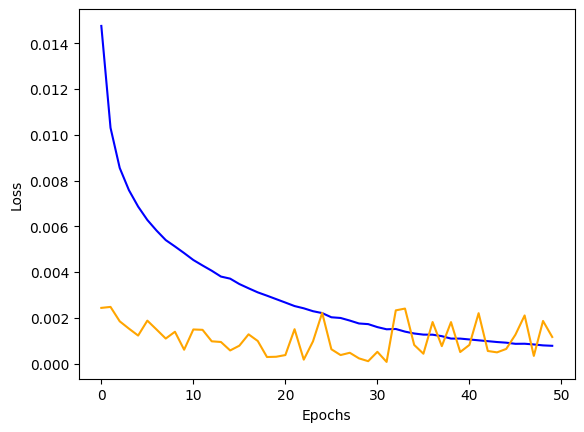

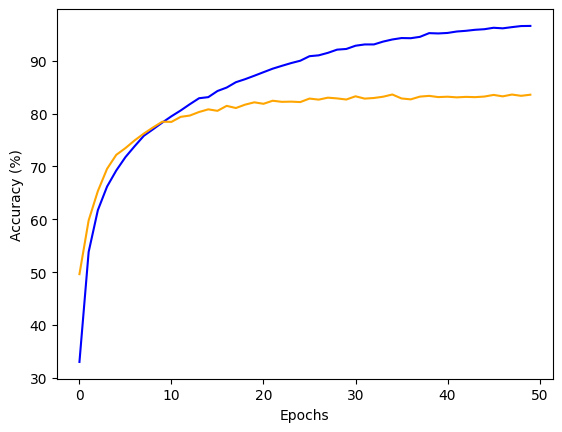

In [14]:
import matplotlib.pyplot as plt

# After the training loop

# Plot training and validation loss
plt.figure()
plt.plot(train_losses, color='blue', label='Train Loss')
plt.plot(valid_losses, color='orange', label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Plot training and validation accuracy
plt.figure()
plt.plot(train_accuracies, color='blue', label='Train Accuracy')
plt.plot(valid_accuracies, color='orange', label='Valid Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.show()